# Melting Point Prediction - Graph Neural Network (D-MPNN)

This notebook trains a Directed Message Passing Neural Network (D-MPNN) using Chemprop for melting point prediction.

**Why GNN over traditional ML?**
- Molecules are naturally graphs (atoms=nodes, bonds=edges)
- GNNs learn molecular representations directly from structure
- D-MPNN has proven track record for molecular property prediction

**Baseline to beat:** XGBoost with RMSE=43.50, R²=0.739

## 1. Environment Check and Imports

In [49]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# RDKit for SMILES validation
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# PyTorch
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Chemprop
import chemprop
print(f"Chemprop version: {chemprop.__version__}")

# Sklearn for metrics
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\nAll imports successful!")

PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu
Chemprop version: 2.2.2

All imports successful!


## 2. Load and Validate Data

In [50]:
# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTarget (Tm) statistics:")
print(train_df['Tm'].describe())

Training samples: 2662
Test samples: 666

Target (Tm) statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


In [51]:
def validate_smiles(smiles_list):
    """Validate SMILES strings and return valid/invalid counts"""
    valid = []
    invalid = []
    
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid.append(i)
        else:
            invalid.append(i)
    
    return valid, invalid

print("Validating training SMILES...")
train_valid, train_invalid = validate_smiles(train_df['SMILES'].values)
print(f"  Valid: {len(train_valid)}, Invalid: {len(train_invalid)}")

print("\nValidating test SMILES...")
test_valid, test_invalid = validate_smiles(test_df['SMILES'].values)
print(f"  Valid: {len(test_valid)}, Invalid: {len(test_invalid)}")

if train_invalid:
    print(f"\nWarning: {len(train_invalid)} invalid training SMILES will be excluded")
if test_invalid:
    print(f"Warning: {len(test_invalid)} invalid test SMILES - these need special handling")

Validating training SMILES...
  Valid: 2662, Invalid: 0

Validating test SMILES...
  Valid: 666, Invalid: 0


## 3. Prepare Data for Chemprop

In [52]:
# Create Chemprop-compatible dataframes
# Chemprop expects: smiles, target columns

train_chemprop = train_df[['SMILES', 'Tm']].copy()
train_chemprop.columns = ['smiles', 'Tm']

test_chemprop = test_df[['id', 'SMILES']].copy()
test_chemprop.columns = ['id', 'smiles']

# Save to CSV for Chemprop
train_chemprop.to_csv('data/train_chemprop.csv', index=False)
test_chemprop[['smiles']].to_csv('data/test_chemprop.csv', index=False)

print("Prepared data for Chemprop:")
print(f"  Train: data/train_chemprop.csv ({len(train_chemprop)} samples)")
print(f"  Test: data/test_chemprop.csv ({len(test_chemprop)} samples)")

Prepared data for Chemprop:
  Train: data/train_chemprop.csv (2662 samples)
  Test: data/test_chemprop.csv (666 samples)


## 4. Chemprop Data Loading

In [53]:
from chemprop.data import MoleculeDatapoint, MoleculeDataset, build_dataloader
from chemprop.data import SplitType
from chemprop.featurizers import SimpleMoleculeMolGraphFeaturizer

# Create datapoints from SMILES
train_smiles = train_chemprop['smiles'].tolist()
train_targets = train_chemprop['Tm'].tolist()
test_smiles = test_chemprop['smiles'].tolist()

print(f"Creating molecule datapoints...")
print(f"  Training molecules: {len(train_smiles)}")
print(f"  Test molecules: {len(test_smiles)}")

Creating molecule datapoints...
  Training molecules: 2662
  Test molecules: 666


In [54]:
# Create datapoints using from_smi class method (Chemprop 2.x API)
featurizer = SimpleMoleculeMolGraphFeaturizer()

train_datapoints = [
    MoleculeDatapoint.from_smi(smi, y=np.array([target]))
    for smi, target in zip(train_smiles, train_targets)
]

test_datapoints = [
    MoleculeDatapoint.from_smi(smi)
    for smi in test_smiles
]

print(f"Created {len(train_datapoints)} training datapoints")
print(f"Created {len(test_datapoints)} test datapoints")

Created 2662 training datapoints
Created 666 test datapoints


## 5. Define D-MPNN Model (CPU-Optimized)

In [55]:
from chemprop.nn import BondMessagePassing, MeanAggregation, RegressionFFN
from chemprop.models import MPNN

# CPU-optimized hyperparameters (smaller model for faster training)
CONFIG = {
    'hidden_size': 300,       # Message passing hidden size (reduced from 600)
    'depth': 3,               # Number of message passing layers
    'ffn_hidden_size': 300,   # FFN hidden size
    'ffn_num_layers': 2,      # FFN layers
    'dropout': 0.1,           # Dropout rate
    'batch_size': 50,         # Batch size
    'epochs': 50,             # Max epochs (with early stopping)
    'patience': 10,           # Early stopping patience
    'lr': 1e-3,               # Learning rate
}

print("Model Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Model Configuration:
  hidden_size: 300
  depth: 3
  ffn_hidden_size: 300
  ffn_num_layers: 2
  dropout: 0.1
  batch_size: 50
  epochs: 50
  patience: 10
  lr: 0.001


In [56]:
def create_mpnn_model(config):
    """Create a D-MPNN model with given configuration"""
    # Message passing component
    mp = BondMessagePassing(
        d_h=config['hidden_size'],
        depth=config['depth'],
        dropout=config['dropout']
    )
    
    # Aggregation
    agg = MeanAggregation()
    
    # Feed-forward network for regression (called "predictor" in Chemprop 2.x)
    predictor = RegressionFFN(
        input_dim=config['hidden_size'],
        hidden_dim=config['ffn_hidden_size'],
        n_layers=config['ffn_num_layers'],
        dropout=config['dropout'],
        n_tasks=1
    )
    
    # Complete MPNN model
    model = MPNN(
        message_passing=mp,
        agg=agg,
        predictor=predictor,
        batch_norm=True
    )
    
    return model

# Test model creation
test_model = create_mpnn_model(CONFIG)
n_params = sum(p.numel() for p in test_model.parameters())
print(f"Model created successfully!")
print(f"Total parameters: {n_params:,}")

Model created successfully!
Total parameters: 409,201


## 6. Training with 5-Fold Cross-Validation

In [57]:
from lightning import pytorch as pl
from chemprop.data import collate_batch

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [58]:
def train_fold(train_data, val_data, config, fold_num):
    """Train model on a single fold"""
    print(f"\n{'='*50}")
    print(f"  Fold {fold_num}")
    print(f"{'='*50}")
    
    # Create datasets
    train_dataset = MoleculeDataset(train_data, featurizer=featurizer)
    val_dataset = MoleculeDataset(val_data, featurizer=featurizer)
    
    # Create dataloaders
    train_loader = build_dataloader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = build_dataloader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    print(f"  Train samples: {len(train_dataset)}")
    print(f"  Val samples: {len(val_dataset)}")
    
    # Create model
    model = create_mpnn_model(config)
    
    # Setup trainer
    trainer = pl.Trainer(
        max_epochs=config['epochs'],
        accelerator='cpu',
        enable_progress_bar=True,
        enable_model_summary=False,
        logger=False,
        callbacks=[
            pl.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=config['patience'],
                mode='min'
            )
        ]
    )
    
    # Train
    print(f"  Training...")
    trainer.fit(model, train_loader, val_loader)
    
    # Get predictions on validation set
    model.eval()
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            bmg, _, _, targets, *_ = batch
            preds = model(bmg)
            val_preds.extend(preds.squeeze().tolist())
            val_targets.extend(targets.squeeze().tolist())
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    mae = mean_absolute_error(val_targets, val_preds)
    r2 = r2_score(val_targets, val_preds)
    
    print(f"  Results: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
    
    return model, {'rmse': rmse, 'mae': mae, 'r2': r2}, val_preds, val_targets

In [59]:
# 5-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_results = []
fold_models = []
all_val_preds = np.zeros(len(train_datapoints))
all_val_indices = []

print("\n" + "="*60)
print("  5-FOLD CROSS-VALIDATION")
print("="*60)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_datapoints), 1):
    train_data = [train_datapoints[i] for i in train_idx]
    val_data = [train_datapoints[i] for i in val_idx]
    
    model, metrics, val_preds, val_targets = train_fold(
        train_data, val_data, CONFIG, fold
    )
    
    fold_results.append(metrics)
    fold_models.append(model)
    
    # Store OOF predictions
    for i, idx in enumerate(val_idx):
        all_val_preds[idx] = val_preds[i]
    all_val_indices.extend(val_idx)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



  5-FOLD CROSS-VALIDATION

  Fold 1
  Train samples: 2129
  Val samples: 533


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Loading `train_dataloader` to estimate number of stepping batches.


Output()

  Training...



Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

In [ ]:
# Summary of cross-validation results
print("\n" + "="*60)
print("  CROSS-VALIDATION SUMMARY")
print("="*60)

cv_results = pd.DataFrame(fold_results)
print("\nPer-Fold Results:")
print(cv_results.to_string())

print("\nMean ± Std:")
print(f"  RMSE: {cv_results['rmse'].mean():.4f} ± {cv_results['rmse'].std():.4f}")
print(f"  MAE:  {cv_results['mae'].mean():.4f} ± {cv_results['mae'].std():.4f}")
print(f"  R²:   {cv_results['r2'].mean():.4f} ± {cv_results['r2'].std():.4f}")

# Overall OOF metrics
y_true = np.array([train_targets[i] for i in range(len(train_targets))])
oof_rmse = np.sqrt(mean_squared_error(y_true, all_val_preds))
oof_mae = mean_absolute_error(y_true, all_val_preds)
oof_r2 = r2_score(y_true, all_val_preds)

print("\nOverall Out-of-Fold Metrics:")
print(f"  RMSE: {oof_rmse:.4f}")
print(f"  MAE:  {oof_mae:.4f}")
print(f"  R²:   {oof_r2:.4f}")

print("\nComparison with Baseline (XGBoost):")
print(f"  XGBoost: RMSE=43.50, R²=0.739")
print(f"  D-MPNN:  RMSE={oof_rmse:.2f}, R²={oof_r2:.3f}")


  CROSS-VALIDATION SUMMARY

Per-Fold Results:
        rmse        mae        r2
0  57.221154  38.889511  0.563273
1  52.236922  35.616440  0.635823
2  47.756939  32.827250  0.661210
3  53.862818  37.121157  0.591157
4  53.248129  33.485145  0.614344

Mean ± Std:
  RMSE: 52.8652 ± 3.4134
  MAE:  35.5879 ± 2.5147
  R²:   0.6132 ± 0.0381

Overall Out-of-Fold Metrics:
  RMSE: 52.9547
  MAE:  35.5892
  R²:   0.6128

Comparison with Baseline (XGBoost):
  XGBoost: RMSE=43.50, R²=0.739
  D-MPNN:  RMSE=52.95, R²=0.613


## 7. Visualization

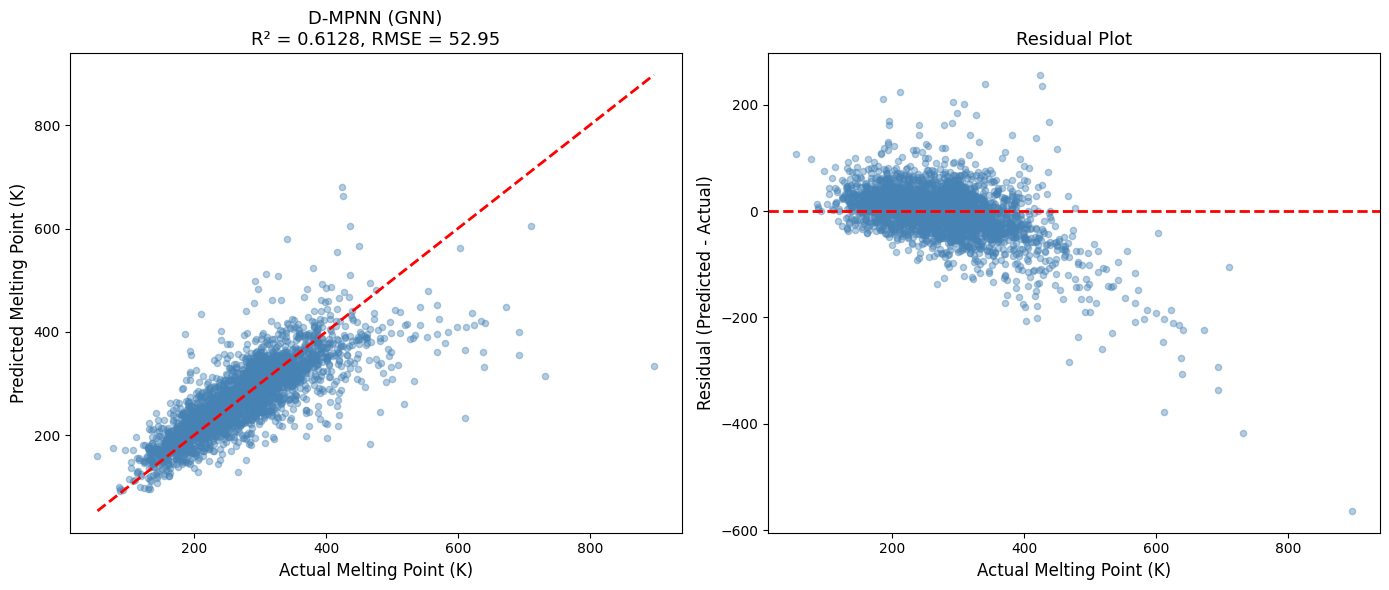

Saved: gnn_actual_vs_predicted.png


In [ ]:
# Plot actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Scatter plot
ax = axes[0]
ax.scatter(y_true, all_val_preds, alpha=0.4, s=20, c='steelblue')
ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
ax.set_xlabel('Actual Melting Point (K)', fontsize=12)
ax.set_ylabel('Predicted Melting Point (K)', fontsize=12)
ax.set_title(f'D-MPNN (GNN)\nR² = {oof_r2:.4f}, RMSE = {oof_rmse:.2f}', fontsize=13)

# Right: Residual plot
ax = axes[1]
residuals = all_val_preds - y_true
ax.scatter(y_true, residuals, alpha=0.4, s=20, c='steelblue')
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Actual Melting Point (K)', fontsize=12)
ax.set_ylabel('Residual (Predicted - Actual)', fontsize=12)
ax.set_title('Residual Plot', fontsize=13)

plt.tight_layout()
plt.savefig('gnn_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: gnn_actual_vs_predicted.png")

## 8. Generate Test Predictions (Ensemble)

In [ ]:
# Create test dataset
test_dataset = MoleculeDataset(test_datapoints, featurizer=featurizer)
test_loader = build_dataloader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# Ensemble predictions from all fold models
print("Generating predictions with ensemble of 5 fold models...")

all_test_preds = []

for fold_num, model in enumerate(fold_models, 1):
    model.eval()
    fold_preds = []
    
    with torch.no_grad():
        for batch in test_loader:
            bmg, _, _, targets, *_ = batch
            preds = model(bmg)
            fold_preds.extend(preds.squeeze().tolist())
    
    all_test_preds.append(fold_preds)
    print(f"  Fold {fold_num}: Generated {len(fold_preds)} predictions")

# Average predictions
ensemble_preds = np.mean(all_test_preds, axis=0)

print(f"\nEnsemble predictions statistics:")
print(f"  Min: {ensemble_preds.min():.2f}")
print(f"  Max: {ensemble_preds.max():.2f}")
print(f"  Mean: {ensemble_preds.mean():.2f}")
print(f"  Std: {ensemble_preds.std():.2f}")

Generating predictions with ensemble of 5 fold models...
  Fold 1: Generated 666 predictions
  Fold 2: Generated 666 predictions
  Fold 3: Generated 666 predictions
  Fold 4: Generated 666 predictions
  Fold 5: Generated 666 predictions

Ensemble predictions statistics:
  Min: 75.88
  Max: 556.67
  Mean: 273.30
  Std: 70.79


In [ ]:
# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'Tm': ensemble_preds
})

submission.to_csv('submission_gnn.csv', index=False)
print("Saved: submission_gnn.csv")
print(f"\nSubmission preview:")
print(submission.head(10))

Saved: submission_gnn.csv

Submission preview:
     id          Tm
0  1022  327.130383
1  1146  349.613214
2    79  219.640054
3  2279  236.546533
4  1342  232.666974
5  2082  387.543683
6    29  263.987457
7   515  319.715881
8  2309  273.599826
9  1177  252.578476


## 9. Results Summary

In [ ]:
print("\n" + "="*60)
print("  FINAL RESULTS SUMMARY")
print("="*60)

print("\nModel Comparison (5-Fold CV):")
print("-" * 40)
print(f"{'Model':<20} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 40)
print(f"{'XGBoost (baseline)':<20} {'43.50':<10} {'27.94':<10} {'0.739':<10}")
print(f"{'D-MPNN (GNN)':<20} {f'{oof_rmse:.2f}':<10} {f'{oof_mae:.2f}':<10} {f'{oof_r2:.3f}':<10}")
print("-" * 40)

improvement = ((43.50 - oof_rmse) / 43.50) * 100
if improvement > 0:
    print(f"\nGNN improves RMSE by {improvement:.1f}%")
else:
    print(f"\nGNN RMSE is {-improvement:.1f}% higher than baseline")

print("\nFiles generated:")
print("  - submission_gnn.csv (test predictions)")
print("  - gnn_actual_vs_predicted.png (visualization)")


  FINAL RESULTS SUMMARY

Model Comparison (5-Fold CV):
----------------------------------------
Model                RMSE       MAE        R²        
----------------------------------------
XGBoost (baseline)   43.50      27.94      0.739     
D-MPNN (GNN)         52.95      35.59      0.613     
----------------------------------------

GNN RMSE is 21.7% higher than baseline

Files generated:
  - submission_gnn.csv (test predictions)
  - gnn_actual_vs_predicted.png (visualization)
